In [7]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc
from sklearn.model_selection import KFold
torch.manual_seed(1)    # reproducible torch:2 np:3
np.random.seed(1)

from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [8]:
def test(data_generator, model):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):
        # move inputs to device before forward
        score = model(d.long().to(device), p.long().to(device), d_mask.long().to(device), p_mask.long().to(device))
        
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        loss_fct = torch.nn.BCELoss()            
        
        label = Variable(torch.from_numpy(np.array(label)).float()).to(device)

        loss = loss_fct(logits, label)
        
        loss_accumulate += loss
        count += 1
        
        logits = logits.detach().cpu().numpy()
        
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()
        
    loss = loss_accumulate/count
    
    fpr, tpr, thresholds = roc_curve(y_label, y_pred)

    try:
        precision = tpr / (tpr + fpr)
    except:
        print("Precision error: tpr: ",tpr,", fpr: ", fpr)
        precision = tpr / (tpr + fpr + 0.00001) 

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    thred_optim = thresholds[5:][np.argmax(f1[5:])]

    print("optimal threshold: " + str(thred_optim))

    y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]

    auc_k = auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: "+ str(average_precision_score(y_label, y_pred)))


    pre = precision_score(y_label, y_pred_s)
    rec = recall_score(y_label, y_pred_s)
    cm1 = confusion_matrix(y_label, y_pred_s)
    print('Confusion Matrix : \n-', cm1)
    print('Recall : ', recall_score(y_label, y_pred_s))
    print('Precision : ', precision_score(y_label, y_pred_s))

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])
    return accuracy1, pre, rec, roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), y_pred, loss.item()


def main(fold_n, lr):
    config = BIN_config_DBPE()
    
    lr = lr
    BATCH_SIZE = config['batch_size']
    train_epoch = 100
    
    loss_history = []
    
    model = BIN_Interaction_Flat(**config)
    model = model.to(device)
    
    if use_cuda and torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, dim = 0)
            
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6, 
              'drop_last': True}

    # dataFolder = './dataset/BindingDB'
    dataFolder = "./dataset/b_cancer/splitted"
    df_train = pd.read_csv(dataFolder + '/train.csv')
    df_val = pd.read_csv(dataFolder + '/val.csv')
    df_test = pd.read_csv(dataFolder + '/test.csv')
    
    training_set = BIN_Data_Encoder(df_train.index.values, df_train.Label.values, df_train)
    training_generator = data.DataLoader(training_set, **params)

    validation_set = BIN_Data_Encoder(df_val.index.values, df_val.Label.values, df_val)
    validation_generator = data.DataLoader(validation_set, **params)
    
    testing_set = BIN_Data_Encoder(df_test.index.values, df_test.Label.values, df_test)
    testing_generator = data.DataLoader(testing_set, **params)
    
    # early stopping
    max_auc = 0
    model_max = copy.deepcopy(model)
    
    print('--- Go for Training ---')
    torch.backends.cudnn.benchmark = True

    resultfile = open('results/b_cancer.csv', 'a')
    resultfile.write('Epoch,AUROC,Accuracy,Precision,Recall,AUPRC,F1\n')
    
    for epo in range(train_epoch):
        model.train()
        for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
            # move inputs to device before forward
            score = model(d.long().to(device), p.long().to(device), d_mask.long().to(device), p_mask.long().to(device))

            label = Variable(torch.from_numpy(np.array(label)).float()).to(device)
            
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss = loss_fct(n, label)
            loss_history.append(loss)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if (i % 100 == 0):
                print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + ' with loss ' + str(loss.cpu().detach().numpy()))
            
        # every epoch test
        with torch.set_grad_enabled(False):
            acc, pre, rec, auc, auprc, f1, logits, loss = test(validation_generator, model)
            if auc > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = auc
            
            print('Validation at Epoch '+ str(epo + 1) + ' :: , AUROC: '+ str(auc) + ' ',' Accuracy: ',acc,' , Precision: ',pre,' , Recall: ',rec,' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1))
            resultfile.write(f'{epo + 1},{auc},{acc},{pre},{rec},{auprc},{f1}\n')
            resultfile.flush()
    
    resultfile.close()
    
    print('--- Go for Testing ---')
    try:
        with torch.set_grad_enabled(False):
            acc, pre, rec, auc, auprc, f1, logits, loss = test(testing_generator, model_max)
            print('Testing :: ','Accuracy: ',acc,' , Precision: ',pre,' , Recall: ',rec,' , AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
    except:
        print('testing failed')
    return model_max, loss_history

--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.7126992


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5458077788352966
AUROC:0.7609001406469761
AUPRC: 0.7838095529914363
Confusion Matrix : 
- [[71  8]
 [31 50]]
Recall :  0.6172839506172839
Precision :  0.8620689655172413
Accuracy :  0.75625
Sensitivity :  0.8987341772151899
Specificity :  0.6172839506172839
Validation at Epoch 1 :: , AUROC: 0.7609001406469761   Accuracy:  0.75625  , Precision:  0.8620689655172413  , Recall:  0.6172839506172839  , AUPRC: 0.7838095529914363 , F1: 0.7012987012987013
Training at Epoch 2 iteration 0 with loss 0.61335796


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4069788157939911
AUROC:0.7809568480300187
AUPRC: 0.7833592380724408
Confusion Matrix : 
- [[42 36]
 [ 8 74]]
Recall :  0.9024390243902439
Precision :  0.6727272727272727
Accuracy :  0.725
Sensitivity :  0.5384615384615384
Specificity :  0.9024390243902439
Validation at Epoch 2 :: , AUROC: 0.7809568480300187   Accuracy:  0.725  , Precision:  0.6727272727272727  , Recall:  0.9024390243902439  , AUPRC: 0.7833592380724408 , F1: 0.725
Training at Epoch 3 iteration 0 with loss 0.6191489


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.41767382621765137
AUROC:0.798125
AUPRC: 0.794435109324847
Confusion Matrix : 
- [[39 41]
 [ 6 74]]
Recall :  0.925
Precision :  0.6434782608695652
Accuracy :  0.70625
Sensitivity :  0.4875
Specificity :  0.925
Validation at Epoch 3 :: , AUROC: 0.798125   Accuracy:  0.70625  , Precision:  0.6434782608695652  , Recall:  0.925  , AUPRC: 0.794435109324847 , F1: 0.6887417218543047
Training at Epoch 4 iteration 0 with loss 0.48550615


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4258006811141968
AUROC:0.7823097358962338
AUPRC: 0.784163053353533
Confusion Matrix : 
- [[41 38]
 [ 8 73]]
Recall :  0.9012345679012346
Precision :  0.6576576576576577
Accuracy :  0.7125
Sensitivity :  0.5189873417721519
Specificity :  0.9012345679012346
Validation at Epoch 4 :: , AUROC: 0.7823097358962338   Accuracy:  0.7125  , Precision:  0.6576576576576577  , Recall:  0.9012345679012346  , AUPRC: 0.784163053353533 , F1: 0.6535947712418301
Training at Epoch 5 iteration 0 with loss 0.59244466


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3960739076137543
AUROC:0.8057508985779027
AUPRC: 0.7935825688394669
Confusion Matrix : 
- [[42 37]
 [ 8 73]]
Recall :  0.9012345679012346
Precision :  0.6636363636363637
Accuracy :  0.71875
Sensitivity :  0.5316455696202531
Specificity :  0.9012345679012346
Validation at Epoch 5 :: , AUROC: 0.8057508985779027   Accuracy:  0.71875  , Precision:  0.6636363636363637  , Recall:  0.9012345679012346  , AUPRC: 0.7935825688394669 , F1: 0.7225806451612903
Training at Epoch 6 iteration 0 with loss 0.57788014


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.39600735902786255
AUROC:0.8012820512820512
AUPRC: 0.8027941427231348
Confusion Matrix : 
- [[43 35]
 [ 9 73]]
Recall :  0.8902439024390244
Precision :  0.6759259259259259
Accuracy :  0.725
Sensitivity :  0.5512820512820513
Specificity :  0.8902439024390244
Validation at Epoch 6 :: , AUROC: 0.8012820512820512   Accuracy:  0.725  , Precision:  0.6759259259259259  , Recall:  0.8902439024390244  , AUPRC: 0.8027941427231348 , F1: 0.7027027027027027
Training at Epoch 7 iteration 0 with loss 0.5164132


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5089762210845947
AUROC:0.80765625
AUPRC: 0.7895482514581071
Confusion Matrix : 
- [[63 17]
 [21 59]]
Recall :  0.7375
Precision :  0.7763157894736842
Accuracy :  0.7625
Sensitivity :  0.7875
Specificity :  0.7375
Validation at Epoch 7 :: , AUROC: 0.80765625   Accuracy:  0.7625  , Precision:  0.7763157894736842  , Recall:  0.7375  , AUPRC: 0.7895482514581071 , F1: 0.7453416149068324
Training at Epoch 8 iteration 0 with loss 0.56753916


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3964926302433014
AUROC:0.8059071729957805
AUPRC: 0.8060342088786483
Confusion Matrix : 
- [[46 33]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.6764705882352942
Accuracy :  0.71875
Sensitivity :  0.5822784810126582
Specificity :  0.8518518518518519
Validation at Epoch 8 :: , AUROC: 0.8059071729957805   Accuracy:  0.71875  , Precision:  0.6764705882352942  , Recall:  0.8518518518518519  , AUPRC: 0.8060342088786483 , F1: 0.7044025157232704
Training at Epoch 9 iteration 0 with loss 0.54859966


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4516292214393616
AUROC:0.8172295184490306
AUPRC: 0.8146264700695742
Confusion Matrix : 
- [[52 26]
 [13 69]]
Recall :  0.8414634146341463
Precision :  0.7263157894736842
Accuracy :  0.75625
Sensitivity :  0.6666666666666666
Specificity :  0.8414634146341463
Validation at Epoch 9 :: , AUROC: 0.8172295184490306   Accuracy:  0.75625  , Precision:  0.7263157894736842  , Recall:  0.8414634146341463  , AUPRC: 0.8146264700695742 , F1: 0.7225806451612903
Training at Epoch 10 iteration 0 with loss 0.4666128


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.32554757595062256
AUROC:0.8023764853033145
AUPRC: 0.7995949647100532
Confusion Matrix : 
- [[31 47]
 [ 3 79]]
Recall :  0.9634146341463414
Precision :  0.626984126984127
Accuracy :  0.6875
Sensitivity :  0.3974358974358974
Specificity :  0.9634146341463414
Validation at Epoch 10 :: , AUROC: 0.8023764853033145   Accuracy:  0.6875  , Precision:  0.626984126984127  , Recall:  0.9634146341463414  , AUPRC: 0.7995949647100532 , F1: 0.7499999999999999
Training at Epoch 11 iteration 0 with loss 0.3994668


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.265621542930603
AUROC:0.8073136427566807
AUPRC: 0.8013985408188576
Confusion Matrix : 
- [[29 50]
 [ 2 79]]
Recall :  0.9753086419753086
Precision :  0.6124031007751938
Accuracy :  0.675
Sensitivity :  0.3670886075949367
Specificity :  0.9753086419753086
Validation at Epoch 11 :: , AUROC: 0.8073136427566807   Accuracy:  0.675  , Precision:  0.6124031007751938  , Recall:  0.9753086419753086  , AUPRC: 0.8013985408188576 , F1: 0.7407407407407407
Training at Epoch 12 iteration 0 with loss 0.49431273


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4305301904678345
AUROC:0.7935614939834348
AUPRC: 0.7818169629412438
Confusion Matrix : 
- [[46 33]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.6764705882352942
Accuracy :  0.71875
Sensitivity :  0.5822784810126582
Specificity :  0.8518518518518519
Validation at Epoch 12 :: , AUROC: 0.7935614939834348   Accuracy:  0.71875  , Precision:  0.6764705882352942  , Recall:  0.8518518518518519  , AUPRC: 0.7818169629412438 , F1: 0.7329192546583853
Training at Epoch 13 iteration 0 with loss 0.39342773


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2971533238887787
AUROC:0.8034375
AUPRC: 0.7984272360764275
Confusion Matrix : 
- [[33 47]
 [ 4 76]]
Recall :  0.95
Precision :  0.6178861788617886
Accuracy :  0.68125
Sensitivity :  0.4125
Specificity :  0.95
Validation at Epoch 13 :: , AUROC: 0.8034375   Accuracy:  0.68125  , Precision:  0.6178861788617886  , Recall:  0.95  , AUPRC: 0.7984272360764275 , F1: 0.7215189873417722
Training at Epoch 14 iteration 0 with loss 0.36032984


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5157952308654785
AUROC:0.79125
AUPRC: 0.7586096549382093
Confusion Matrix : 
- [[58 22]
 [20 60]]
Recall :  0.75
Precision :  0.7317073170731707
Accuracy :  0.7375
Sensitivity :  0.725
Specificity :  0.75
Validation at Epoch 14 :: , AUROC: 0.79125   Accuracy:  0.7375  , Precision:  0.7317073170731707  , Recall:  0.75  , AUPRC: 0.7586096549382093 , F1: 0.7317073170731706
Training at Epoch 15 iteration 0 with loss 0.45883495


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4902789294719696
AUROC:0.8228580362726704
AUPRC: 0.8137792603846141
Confusion Matrix : 
- [[60 18]
 [17 65]]
Recall :  0.7926829268292683
Precision :  0.7831325301204819
Accuracy :  0.78125
Sensitivity :  0.7692307692307693
Specificity :  0.7926829268292683
Validation at Epoch 15 :: , AUROC: 0.8228580362726704   Accuracy:  0.78125  , Precision:  0.7831325301204819  , Recall:  0.7926829268292683  , AUPRC: 0.8137792603846141 , F1: 0.7654320987654322
Training at Epoch 16 iteration 0 with loss 0.38027975


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5169439315795898
AUROC:0.8332551961243945
AUPRC: 0.8233291900013576
Confusion Matrix : 
- [[57 22]
 [13 68]]
Recall :  0.8395061728395061
Precision :  0.7555555555555555
Accuracy :  0.78125
Sensitivity :  0.7215189873417721
Specificity :  0.8395061728395061
Validation at Epoch 16 :: , AUROC: 0.8332551961243945   Accuracy:  0.78125  , Precision:  0.7555555555555555  , Recall:  0.8395061728395061  , AUPRC: 0.8233291900013576 , F1: 0.7727272727272727
Training at Epoch 17 iteration 0 with loss 0.46494114


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5205532312393188
AUROC:0.8171875000000001
AUPRC: 0.8185357515614504
Confusion Matrix : 
- [[62 18]
 [21 59]]
Recall :  0.7375
Precision :  0.7662337662337663
Accuracy :  0.75625
Sensitivity :  0.775
Specificity :  0.7375
Validation at Epoch 17 :: , AUROC: 0.8171875000000001   Accuracy:  0.75625  , Precision:  0.7662337662337663  , Recall:  0.7375  , AUPRC: 0.8185357515614504 , F1: 0.75
Training at Epoch 18 iteration 0 with loss 0.4089066


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4102897047996521
AUROC:0.8235661822159712
AUPRC: 0.823782836701407
Confusion Matrix : 
- [[46 33]
 [10 71]]
Recall :  0.8765432098765432
Precision :  0.6826923076923077
Accuracy :  0.73125
Sensitivity :  0.5822784810126582
Specificity :  0.8765432098765432
Validation at Epoch 18 :: , AUROC: 0.8235661822159712   Accuracy:  0.73125  , Precision:  0.6826923076923077  , Recall:  0.8765432098765432  , AUPRC: 0.823782836701407 , F1: 0.7411764705882353
Training at Epoch 19 iteration 0 with loss 0.41491604


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5216375589370728
AUROC:0.8230973589623378
AUPRC: 0.8226301190980446
Confusion Matrix : 
- [[63 16]
 [20 61]]
Recall :  0.7530864197530864
Precision :  0.7922077922077922
Accuracy :  0.775
Sensitivity :  0.7974683544303798
Specificity :  0.7530864197530864
Validation at Epoch 19 :: , AUROC: 0.8230973589623378   Accuracy:  0.775  , Precision:  0.7922077922077922  , Recall:  0.7530864197530864  , AUPRC: 0.8226301190980446 , F1: 0.7701863354037267
Training at Epoch 20 iteration 0 with loss 0.5240984


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.48781147599220276
AUROC:0.8157524613220815
AUPRC: 0.8108348172705295
Confusion Matrix : 
- [[59 20]
 [19 62]]
Recall :  0.7654320987654321
Precision :  0.7560975609756098
Accuracy :  0.75625
Sensitivity :  0.7468354430379747
Specificity :  0.7654320987654321
Validation at Epoch 20 :: , AUROC: 0.8157524613220815   Accuracy:  0.75625  , Precision:  0.7560975609756098  , Recall:  0.7654320987654321  , AUPRC: 0.8108348172705295 , F1: 0.7547169811320754
Training at Epoch 21 iteration 0 with loss 0.46588847


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5410048961639404
AUROC:0.8239062500000001
AUPRC: 0.8154280638268251
Confusion Matrix : 
- [[62 18]
 [20 60]]
Recall :  0.75
Precision :  0.7692307692307693
Accuracy :  0.7625
Sensitivity :  0.775
Specificity :  0.75
Validation at Epoch 21 :: , AUROC: 0.8239062500000001   Accuracy:  0.7625  , Precision:  0.7692307692307693  , Recall:  0.75  , AUPRC: 0.8154280638268251 , F1: 0.7469879518072289
Training at Epoch 22 iteration 0 with loss 0.3582633


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3906395733356476
AUROC:0.80484375
AUPRC: 0.7779156318796752
Confusion Matrix : 
- [[46 34]
 [11 69]]
Recall :  0.8625
Precision :  0.6699029126213593
Accuracy :  0.71875
Sensitivity :  0.575
Specificity :  0.8625
Validation at Epoch 22 :: , AUROC: 0.80484375   Accuracy:  0.71875  , Precision:  0.6699029126213593  , Recall:  0.8625  , AUPRC: 0.7779156318796752 , F1: 0.7329192546583853
Training at Epoch 23 iteration 0 with loss 0.37926266


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4771018922328949
AUROC:0.813125
AUPRC: 0.8184138891804781
Confusion Matrix : 
- [[58 22]
 [17 63]]
Recall :  0.7875
Precision :  0.7411764705882353
Accuracy :  0.75625
Sensitivity :  0.725
Specificity :  0.7875
Validation at Epoch 23 :: , AUROC: 0.813125   Accuracy:  0.75625  , Precision:  0.7411764705882353  , Recall:  0.7875  , AUPRC: 0.8184138891804781 , F1: 0.7530864197530863
Training at Epoch 24 iteration 0 with loss 0.5674726


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4937348961830139
AUROC:0.8305429510248786
AUPRC: 0.854983549015468
Confusion Matrix : 
- [[53 24]
 [16 67]]
Recall :  0.8072289156626506
Precision :  0.7362637362637363
Accuracy :  0.75
Sensitivity :  0.6883116883116883
Specificity :  0.8072289156626506
Validation at Epoch 24 :: , AUROC: 0.8305429510248786   Accuracy:  0.75  , Precision:  0.7362637362637363  , Recall:  0.8072289156626506  , AUPRC: 0.854983549015468 , F1: 0.7558139534883721
Training at Epoch 25 iteration 0 with loss 0.36897472


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3950147032737732
AUROC:0.8196593217690263
AUPRC: 0.8304960726048354
Confusion Matrix : 
- [[46 33]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.6764705882352942
Accuracy :  0.71875
Sensitivity :  0.5822784810126582
Specificity :  0.8518518518518519
Validation at Epoch 25 :: , AUROC: 0.8196593217690263   Accuracy:  0.71875  , Precision:  0.6764705882352942  , Recall:  0.8518518518518519  , AUPRC: 0.8304960726048354 , F1: 0.7204968944099378
Training at Epoch 26 iteration 0 with loss 0.3795788


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.43979141116142273
AUROC:0.8193749999999999
AUPRC: 0.8251560523048163
Confusion Matrix : 
- [[55 25]
 [14 66]]
Recall :  0.825
Precision :  0.7252747252747253
Accuracy :  0.75625
Sensitivity :  0.6875
Specificity :  0.825
Validation at Epoch 26 :: , AUROC: 0.8193749999999999   Accuracy:  0.75625  , Precision:  0.7252747252747253  , Recall:  0.825  , AUPRC: 0.8251560523048163 , F1: 0.75
Training at Epoch 27 iteration 0 with loss 0.3524387


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2944623827934265
AUROC:0.82234375
AUPRC: 0.8350682655649366
Confusion Matrix : 
- [[46 34]
 [11 69]]
Recall :  0.8625
Precision :  0.6699029126213593
Accuracy :  0.71875
Sensitivity :  0.575
Specificity :  0.8625
Validation at Epoch 27 :: , AUROC: 0.82234375   Accuracy:  0.71875  , Precision:  0.6699029126213593  , Recall:  0.8625  , AUPRC: 0.8350682655649366 , F1: 0.7027027027027027
Training at Epoch 28 iteration 0 with loss 0.48227304


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.35325154662132263
AUROC:0.8203723986856516
AUPRC: 0.835524287272463
Confusion Matrix : 
- [[50 27]
 [13 70]]
Recall :  0.8433734939759037
Precision :  0.7216494845360825
Accuracy :  0.75
Sensitivity :  0.6493506493506493
Specificity :  0.8433734939759037
Validation at Epoch 28 :: , AUROC: 0.8203723986856516   Accuracy:  0.75  , Precision:  0.7216494845360825  , Recall:  0.8433734939759037  , AUPRC: 0.835524287272463 , F1: 0.7361963190184048
Training at Epoch 29 iteration 0 with loss 0.42813048


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4059869945049286
AUROC:0.8253125
AUPRC: 0.8358953043442243
Confusion Matrix : 
- [[48 32]
 [10 70]]
Recall :  0.875
Precision :  0.6862745098039216
Accuracy :  0.7375
Sensitivity :  0.6
Specificity :  0.875
Validation at Epoch 29 :: , AUROC: 0.8253125   Accuracy:  0.7375  , Precision:  0.6862745098039216  , Recall:  0.875  , AUPRC: 0.8358953043442243 , F1: 0.7529411764705882
Training at Epoch 30 iteration 0 with loss 0.35886145


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.40735194087028503
AUROC:0.823722456633849
AUPRC: 0.8433799331149008
Confusion Matrix : 
- [[52 27]
 [15 66]]
Recall :  0.8148148148148148
Precision :  0.7096774193548387
Accuracy :  0.7375
Sensitivity :  0.6582278481012658
Specificity :  0.8148148148148148
Validation at Epoch 30 :: , AUROC: 0.823722456633849   Accuracy:  0.7375  , Precision:  0.7096774193548387  , Recall:  0.8148148148148148  , AUPRC: 0.8433799331149008 , F1: 0.7515151515151515
Training at Epoch 31 iteration 0 with loss 0.3248649


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.44783926010131836
AUROC:0.8202844194405375
AUPRC: 0.8281078590122857
Confusion Matrix : 
- [[52 27]
 [13 68]]
Recall :  0.8395061728395061
Precision :  0.7157894736842105
Accuracy :  0.75
Sensitivity :  0.6582278481012658
Specificity :  0.8395061728395061
Validation at Epoch 31 :: , AUROC: 0.8202844194405375   Accuracy:  0.75  , Precision:  0.7157894736842105  , Recall:  0.8395061728395061  , AUPRC: 0.8281078590122857 , F1: 0.7682926829268293
Training at Epoch 32 iteration 0 with loss 0.44317394


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.39126184582710266
AUROC:0.8205128205128205
AUPRC: 0.8264777171750861
Confusion Matrix : 
- [[55 23]
 [15 67]]
Recall :  0.8170731707317073
Precision :  0.7444444444444445
Accuracy :  0.7625
Sensitivity :  0.7051282051282052
Specificity :  0.8170731707317073
Validation at Epoch 32 :: , AUROC: 0.8205128205128205   Accuracy:  0.7625  , Precision:  0.7444444444444445  , Recall:  0.8170731707317073  , AUPRC: 0.8264777171750861 , F1: 0.7341772151898733
Training at Epoch 33 iteration 0 with loss 0.41354167


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4895813465118408
AUROC:0.8099703078606032
AUPRC: 0.8137061427479552
Confusion Matrix : 
- [[58 21]
 [17 64]]
Recall :  0.7901234567901234
Precision :  0.7529411764705882
Accuracy :  0.7625
Sensitivity :  0.7341772151898734
Specificity :  0.7901234567901234
Validation at Epoch 33 :: , AUROC: 0.8099703078606032   Accuracy:  0.7625  , Precision:  0.7529411764705882  , Recall:  0.7901234567901234  , AUPRC: 0.8137061427479552 , F1: 0.7577639751552795
Training at Epoch 34 iteration 0 with loss 0.29121098


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.28417953848838806
AUROC:0.8299734333489608
AUPRC: 0.8255429620275091
Confusion Matrix : 
- [[46 35]
 [ 8 71]]
Recall :  0.8987341772151899
Precision :  0.6698113207547169
Accuracy :  0.73125
Sensitivity :  0.5679012345679012
Specificity :  0.8987341772151899
Validation at Epoch 34 :: , AUROC: 0.8299734333489608   Accuracy:  0.73125  , Precision:  0.6698113207547169  , Recall:  0.8987341772151899  , AUPRC: 0.8255429620275091 , F1: 0.7530864197530864
Training at Epoch 35 iteration 0 with loss 0.26318172


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4768453538417816
AUROC:0.8321875
AUPRC: 0.8310350591447364
Confusion Matrix : 
- [[57 23]
 [13 67]]
Recall :  0.8375
Precision :  0.7444444444444445
Accuracy :  0.775
Sensitivity :  0.7125
Specificity :  0.8375
Validation at Epoch 35 :: , AUROC: 0.8321875   Accuracy:  0.775  , Precision:  0.7444444444444445  , Recall:  0.8375  , AUPRC: 0.8310350591447364 , F1: 0.778443113772455
Training at Epoch 36 iteration 0 with loss 0.31443298


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3695233464241028
AUROC:0.8138771683075481
AUPRC: 0.8295834346253633
Confusion Matrix : 
- [[50 29]
 [11 70]]
Recall :  0.8641975308641975
Precision :  0.7070707070707071
Accuracy :  0.75
Sensitivity :  0.6329113924050633
Specificity :  0.8641975308641975
Validation at Epoch 36 :: , AUROC: 0.8138771683075481   Accuracy:  0.75  , Precision:  0.7070707070707071  , Recall:  0.8641975308641975  , AUPRC: 0.8295834346253633 , F1: 0.7636363636363638
Training at Epoch 37 iteration 0 with loss 0.31478778


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.5364622473716736
AUROC:0.8173152055008595
AUPRC: 0.8340773915272353
Confusion Matrix : 
- [[56 23]
 [16 65]]
Recall :  0.8024691358024691
Precision :  0.7386363636363636
Accuracy :  0.75625
Sensitivity :  0.7088607594936709
Specificity :  0.8024691358024691
Validation at Epoch 37 :: , AUROC: 0.8173152055008595   Accuracy:  0.75625  , Precision:  0.7386363636363636  , Recall:  0.8024691358024691  , AUPRC: 0.8340773915272353 , F1: 0.7586206896551724
Training at Epoch 38 iteration 0 with loss 0.347129


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4822934865951538
AUROC:0.8293483356774496
AUPRC: 0.8385603053686109
Confusion Matrix : 
- [[55 24]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.7419354838709677
Accuracy :  0.775
Sensitivity :  0.6962025316455697
Specificity :  0.8518518518518519
Validation at Epoch 38 :: , AUROC: 0.8293483356774496   Accuracy:  0.775  , Precision:  0.7419354838709677  , Recall:  0.8518518518518519  , AUPRC: 0.8385603053686109 , F1: 0.7861271676300579
Training at Epoch 39 iteration 0 with loss 0.3650459


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.31889107823371887
AUROC:0.808563838099703
AUPRC: 0.8221529356977514
Confusion Matrix : 
- [[40 39]
 [ 8 73]]
Recall :  0.9012345679012346
Precision :  0.6517857142857143
Accuracy :  0.70625
Sensitivity :  0.5063291139240507
Specificity :  0.9012345679012346
Validation at Epoch 39 :: , AUROC: 0.808563838099703   Accuracy:  0.70625  , Precision:  0.6517857142857143  , Recall:  0.9012345679012346  , AUPRC: 0.8221529356977514 , F1: 0.7349397590361447
Training at Epoch 40 iteration 0 with loss 0.2786524


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3089740574359894
AUROC:0.8190342240975153
AUPRC: 0.8216402202062383
Confusion Matrix : 
- [[51 28]
 [ 9 72]]
Recall :  0.8888888888888888
Precision :  0.72
Accuracy :  0.76875
Sensitivity :  0.6455696202531646
Specificity :  0.8888888888888888
Validation at Epoch 40 :: , AUROC: 0.8190342240975153   Accuracy:  0.76875  , Precision:  0.72  , Recall:  0.8888888888888888  , AUPRC: 0.8216402202062383 , F1: 0.717948717948718
Training at Epoch 41 iteration 0 with loss 0.24350455


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.38253700733184814
AUROC:0.8139062499999999
AUPRC: 0.8194256960209849
Confusion Matrix : 
- [[52 28]
 [13 67]]
Recall :  0.8375
Precision :  0.7052631578947368
Accuracy :  0.74375
Sensitivity :  0.65
Specificity :  0.8375
Validation at Epoch 41 :: , AUROC: 0.8139062499999999   Accuracy:  0.74375  , Precision:  0.7052631578947368  , Recall:  0.8375  , AUPRC: 0.8194256960209849 , F1: 0.7317073170731706
Training at Epoch 42 iteration 0 with loss 0.3731943


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.42417967319488525
AUROC:0.8142700672821155
AUPRC: 0.8391339714610451
Confusion Matrix : 
- [[49 28]
 [15 68]]
Recall :  0.8192771084337349
Precision :  0.7083333333333334
Accuracy :  0.73125
Sensitivity :  0.6363636363636364
Specificity :  0.8192771084337349
Validation at Epoch 42 :: , AUROC: 0.8142700672821155   Accuracy:  0.73125  , Precision:  0.7083333333333334  , Recall:  0.8192771084337349  , AUPRC: 0.8391339714610451 , F1: 0.7455621301775147
Training at Epoch 43 iteration 0 with loss 0.22262691


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3166714608669281
AUROC:0.8218749999999999
AUPRC: 0.8367716778802614
Confusion Matrix : 
- [[49 31]
 [11 69]]
Recall :  0.8625
Precision :  0.69
Accuracy :  0.7375
Sensitivity :  0.6125
Specificity :  0.8625
Validation at Epoch 43 :: , AUROC: 0.8218749999999999   Accuracy:  0.7375  , Precision:  0.69  , Recall:  0.8625  , AUPRC: 0.8367716778802614 , F1: 0.7329192546583853
Training at Epoch 44 iteration 0 with loss 0.28977704


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4425489008426666
AUROC:0.8241088180112571
AUPRC: 0.8353242176033094
Confusion Matrix : 
- [[54 24]
 [15 67]]
Recall :  0.8170731707317073
Precision :  0.7362637362637363
Accuracy :  0.75625
Sensitivity :  0.6923076923076923
Specificity :  0.8170731707317073
Validation at Epoch 44 :: , AUROC: 0.8241088180112571   Accuracy:  0.75625  , Precision:  0.7362637362637363  , Recall:  0.8170731707317073  , AUPRC: 0.8353242176033094 , F1: 0.757396449704142
Training at Epoch 45 iteration 0 with loss 0.28147507


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.37643343210220337
AUROC:0.8256249999999999
AUPRC: 0.836879083769652
Confusion Matrix : 
- [[50 30]
 [ 9 71]]
Recall :  0.8875
Precision :  0.7029702970297029
Accuracy :  0.75625
Sensitivity :  0.625
Specificity :  0.8875
Validation at Epoch 45 :: , AUROC: 0.8256249999999999   Accuracy:  0.75625  , Precision:  0.7029702970297029  , Recall:  0.8875  , AUPRC: 0.836879083769652 , F1: 0.7455621301775148
Training at Epoch 46 iteration 0 with loss 0.27302814


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.32903268933296204
AUROC:0.81671875
AUPRC: 0.8269173964968026
Confusion Matrix : 
- [[39 41]
 [ 7 73]]
Recall :  0.9125
Precision :  0.6403508771929824
Accuracy :  0.7
Sensitivity :  0.4875
Specificity :  0.9125
Validation at Epoch 46 :: , AUROC: 0.81671875   Accuracy:  0.7  , Precision:  0.6403508771929824  , Recall:  0.9125  , AUPRC: 0.8269173964968026 , F1: 0.7303370786516853
Training at Epoch 47 iteration 0 with loss 0.30630955


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.36330878734588623
AUROC:0.82046875
AUPRC: 0.8396415891786948
Confusion Matrix : 
- [[49 31]
 [10 70]]
Recall :  0.875
Precision :  0.693069306930693
Accuracy :  0.74375
Sensitivity :  0.6125
Specificity :  0.875
Validation at Epoch 47 :: , AUROC: 0.82046875   Accuracy:  0.74375  , Precision:  0.693069306930693  , Recall:  0.875  , AUPRC: 0.8396415891786948 , F1: 0.7590361445783131
Training at Epoch 48 iteration 0 with loss 0.37727967


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3372552692890167
AUROC:0.8250664997652949
AUPRC: 0.8484053202699493
Confusion Matrix : 
- [[46 31]
 [10 73]]
Recall :  0.8795180722891566
Precision :  0.7019230769230769
Accuracy :  0.74375
Sensitivity :  0.5974025974025974
Specificity :  0.8795180722891566
Validation at Epoch 48 :: , AUROC: 0.8250664997652949   Accuracy:  0.74375  , Precision:  0.7019230769230769  , Recall:  0.8795180722891566  , AUPRC: 0.8484053202699493 , F1: 0.7701149425287357
Training at Epoch 49 iteration 0 with loss 0.263284


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.35500863194465637
AUROC:0.8170312500000001
AUPRC: 0.8327040861741373
Confusion Matrix : 
- [[47 33]
 [10 70]]
Recall :  0.875
Precision :  0.6796116504854369
Accuracy :  0.73125
Sensitivity :  0.5875
Specificity :  0.875
Validation at Epoch 49 :: , AUROC: 0.8170312500000001   Accuracy:  0.73125  , Precision:  0.6796116504854369  , Recall:  0.875  , AUPRC: 0.8327040861741373 , F1: 0.7411764705882352
Training at Epoch 50 iteration 0 with loss 0.3231061


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.36787188053131104
AUROC:0.8215625
AUPRC: 0.8361025125244875
Confusion Matrix : 
- [[46 34]
 [ 8 72]]
Recall :  0.9
Precision :  0.6792452830188679
Accuracy :  0.7375
Sensitivity :  0.575
Specificity :  0.9
Validation at Epoch 50 :: , AUROC: 0.8215625   Accuracy:  0.7375  , Precision:  0.6792452830188679  , Recall:  0.9  , AUPRC: 0.8361025125244875 , F1: 0.7630057803468208
Training at Epoch 51 iteration 0 with loss 0.24947329


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3469242453575134
AUROC:0.81546875
AUPRC: 0.8297104660773649
Confusion Matrix : 
- [[54 26]
 [13 67]]
Recall :  0.8375
Precision :  0.7204301075268817
Accuracy :  0.75625
Sensitivity :  0.675
Specificity :  0.8375
Validation at Epoch 51 :: , AUROC: 0.81546875   Accuracy:  0.75625  , Precision:  0.7204301075268817  , Recall:  0.8375  , AUPRC: 0.8297104660773649 , F1: 0.7204968944099378
Training at Epoch 52 iteration 0 with loss 0.28664154


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4286080002784729
AUROC:0.8348179403031722
AUPRC: 0.852454976758301
Confusion Matrix : 
- [[47 32]
 [ 8 73]]
Recall :  0.9012345679012346
Precision :  0.6952380952380952
Accuracy :  0.75
Sensitivity :  0.5949367088607594
Specificity :  0.9012345679012346
Validation at Epoch 52 :: , AUROC: 0.8348179403031722   Accuracy:  0.75  , Precision:  0.6952380952380952  , Recall:  0.9012345679012346  , AUPRC: 0.852454976758301 , F1: 0.7555555555555555
Training at Epoch 53 iteration 0 with loss 0.18162602


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3343430459499359
AUROC:0.8288795124238162
AUPRC: 0.8333863400361567
Confusion Matrix : 
- [[52 29]
 [11 68]]
Recall :  0.8607594936708861
Precision :  0.7010309278350515
Accuracy :  0.75
Sensitivity :  0.6419753086419753
Specificity :  0.8607594936708861
Validation at Epoch 53 :: , AUROC: 0.8288795124238162   Accuracy:  0.75  , Precision:  0.7010309278350515  , Recall:  0.8607594936708861  , AUPRC: 0.8333863400361567 , F1: 0.75
Training at Epoch 54 iteration 0 with loss 0.25467375


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2917810380458832
AUROC:0.823125
AUPRC: 0.8340781107950919
Confusion Matrix : 
- [[48 32]
 [ 9 71]]
Recall :  0.8875
Precision :  0.6893203883495146
Accuracy :  0.74375
Sensitivity :  0.6
Specificity :  0.8875
Validation at Epoch 54 :: , AUROC: 0.823125   Accuracy:  0.74375  , Precision:  0.6893203883495146  , Recall:  0.8875  , AUPRC: 0.8340781107950919 , F1: 0.7500000000000001
Training at Epoch 55 iteration 0 with loss 0.24096616


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.31052035093307495
AUROC:0.8310673542741053
AUPRC: 0.8464811458759522
Confusion Matrix : 
- [[53 26]
 [10 71]]
Recall :  0.8765432098765432
Precision :  0.7319587628865979
Accuracy :  0.775
Sensitivity :  0.6708860759493671
Specificity :  0.8765432098765432
Validation at Epoch 55 :: , AUROC: 0.8310673542741053   Accuracy:  0.775  , Precision:  0.7319587628865979  , Recall:  0.8765432098765432  , AUPRC: 0.8464811458759522 , F1: 0.7547169811320754
Training at Epoch 56 iteration 0 with loss 0.2953922


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.21457993984222412
AUROC:0.8078125
AUPRC: 0.8243395928353328
Confusion Matrix : 
- [[43 37]
 [ 7 73]]
Recall :  0.9125
Precision :  0.6636363636363637
Accuracy :  0.725
Sensitivity :  0.5375
Specificity :  0.9125
Validation at Epoch 56 :: , AUROC: 0.8078125   Accuracy:  0.725  , Precision:  0.6636363636363637  , Recall:  0.9125  , AUPRC: 0.8243395928353328 , F1: 0.7307692307692308
Training at Epoch 57 iteration 0 with loss 0.17349042


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2712673544883728
AUROC:0.8212945590994372
AUPRC: 0.8418173143419536
Confusion Matrix : 
- [[47 31]
 [10 72]]
Recall :  0.8780487804878049
Precision :  0.6990291262135923
Accuracy :  0.74375
Sensitivity :  0.6025641025641025
Specificity :  0.8780487804878049
Validation at Epoch 57 :: , AUROC: 0.8212945590994372   Accuracy:  0.74375  , Precision:  0.6990291262135923  , Recall:  0.8780487804878049  , AUPRC: 0.8418173143419536 , F1: 0.7738095238095238
Training at Epoch 58 iteration 0 with loss 0.2738356


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.4731740355491638
AUROC:0.8264540337711069
AUPRC: 0.8435058605310306
Confusion Matrix : 
- [[54 24]
 [13 69]]
Recall :  0.8414634146341463
Precision :  0.7419354838709677
Accuracy :  0.76875
Sensitivity :  0.6923076923076923
Specificity :  0.8414634146341463
Validation at Epoch 58 :: , AUROC: 0.8264540337711069   Accuracy:  0.76875  , Precision:  0.7419354838709677  , Recall:  0.8414634146341463  , AUPRC: 0.8435058605310306 , F1: 0.7745664739884394
Training at Epoch 59 iteration 0 with loss 0.15677446


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3247380554676056
AUROC:0.8238787310517268
AUPRC: 0.8322027366066533
Confusion Matrix : 
- [[54 25]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.7340425531914894
Accuracy :  0.76875
Sensitivity :  0.6835443037974683
Specificity :  0.8518518518518519
Validation at Epoch 59 :: , AUROC: 0.8238787310517268   Accuracy:  0.76875  , Precision:  0.7340425531914894  , Recall:  0.8518518518518519  , AUPRC: 0.8322027366066533 , F1: 0.7625
Training at Epoch 60 iteration 0 with loss 0.18301705


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2972874343395233
AUROC:0.8082512892639475
AUPRC: 0.7775513219459969
Confusion Matrix : 
- [[52 27]
 [10 71]]
Recall :  0.8765432098765432
Precision :  0.7244897959183674
Accuracy :  0.76875
Sensitivity :  0.6582278481012658
Specificity :  0.8765432098765432
Validation at Epoch 60 :: , AUROC: 0.8082512892639475   Accuracy:  0.76875  , Precision:  0.7244897959183674  , Recall:  0.8765432098765432  , AUPRC: 0.7775513219459969 , F1: 0.7560975609756098
Training at Epoch 61 iteration 0 with loss 0.22373372


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.27243906259536743
AUROC:0.8026254102203468
AUPRC: 0.8199468994228715
Confusion Matrix : 
- [[41 38]
 [ 7 74]]
Recall :  0.9135802469135802
Precision :  0.6607142857142857
Accuracy :  0.71875
Sensitivity :  0.5189873417721519
Specificity :  0.9135802469135802
Validation at Epoch 61 :: , AUROC: 0.8026254102203468   Accuracy:  0.71875  , Precision:  0.6607142857142857  , Recall:  0.9135802469135802  , AUPRC: 0.8199468994228715 , F1: 0.6976744186046511
Training at Epoch 62 iteration 0 with loss 0.17899841


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.32679852843284607
AUROC:0.83296875
AUPRC: 0.847598675244771
Confusion Matrix : 
- [[55 25]
 [12 68]]
Recall :  0.85
Precision :  0.7311827956989247
Accuracy :  0.76875
Sensitivity :  0.6875
Specificity :  0.85
Validation at Epoch 62 :: , AUROC: 0.83296875   Accuracy:  0.76875  , Precision:  0.7311827956989247  , Recall:  0.85  , AUPRC: 0.847598675244771 , F1: 0.7295597484276729
Training at Epoch 63 iteration 0 with loss 0.27529374


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2708836793899536
AUROC:0.82484375
AUPRC: 0.846015900078452
Confusion Matrix : 
- [[43 37]
 [ 8 72]]
Recall :  0.9
Precision :  0.6605504587155964
Accuracy :  0.71875
Sensitivity :  0.5375
Specificity :  0.9
Validation at Epoch 63 :: , AUROC: 0.82484375   Accuracy:  0.71875  , Precision:  0.6605504587155964  , Recall:  0.9  , AUPRC: 0.846015900078452 , F1: 0.7209302325581396
Training at Epoch 64 iteration 0 with loss 0.2122972


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.38328009843826294
AUROC:0.8312236286919831
AUPRC: 0.8425093431618949
Confusion Matrix : 
- [[56 23]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.75
Accuracy :  0.78125
Sensitivity :  0.7088607594936709
Specificity :  0.8518518518518519
Validation at Epoch 64 :: , AUROC: 0.8312236286919831   Accuracy:  0.78125  , Precision:  0.75  , Recall:  0.8518518518518519  , AUPRC: 0.8425093431618949 , F1: 0.7636363636363638
Training at Epoch 65 iteration 0 with loss 0.22855304


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3281235694885254
AUROC:0.8087499999999999
AUPRC: 0.8193517568616875
Confusion Matrix : 
- [[48 32]
 [11 69]]
Recall :  0.8625
Precision :  0.6831683168316832
Accuracy :  0.73125
Sensitivity :  0.6
Specificity :  0.8625
Validation at Epoch 65 :: , AUROC: 0.8087499999999999   Accuracy:  0.73125  , Precision:  0.6831683168316832  , Recall:  0.8625  , AUPRC: 0.8193517568616875 , F1: 0.7455621301775148
Training at Epoch 66 iteration 0 with loss 0.15808828


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.20962925255298615
AUROC:0.8045312499999999
AUPRC: 0.8142895543509224
Confusion Matrix : 
- [[40 40]
 [ 6 74]]
Recall :  0.925
Precision :  0.6491228070175439
Accuracy :  0.7125
Sensitivity :  0.5
Specificity :  0.925
Validation at Epoch 66 :: , AUROC: 0.8045312499999999   Accuracy:  0.7125  , Precision:  0.6491228070175439  , Recall:  0.925  , AUPRC: 0.8142895543509224 , F1: 0.7176470588235294
Training at Epoch 67 iteration 0 with loss 0.21293664


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3688730299472809
AUROC:0.8174714799187373
AUPRC: 0.8318871463279816
Confusion Matrix : 
- [[44 35]
 [ 9 72]]
Recall :  0.8888888888888888
Precision :  0.6728971962616822
Accuracy :  0.725
Sensitivity :  0.5569620253164557
Specificity :  0.8888888888888888
Validation at Epoch 67 :: , AUROC: 0.8174714799187373   Accuracy:  0.725  , Precision:  0.6728971962616822  , Recall:  0.8888888888888888  , AUPRC: 0.8318871463279816 , F1: 0.7472527472527474
Training at Epoch 68 iteration 0 with loss 0.1956484


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3261758089065552
AUROC:0.8309881175734836
AUPRC: 0.8485352832173423
Confusion Matrix : 
- [[49 29]
 [11 71]]
Recall :  0.8658536585365854
Precision :  0.71
Accuracy :  0.75
Sensitivity :  0.6282051282051282
Specificity :  0.8658536585365854
Validation at Epoch 68 :: , AUROC: 0.8309881175734836   Accuracy:  0.75  , Precision:  0.71  , Recall:  0.8658536585365854  , AUPRC: 0.8485352832173423 , F1: 0.7790697674418605
Training at Epoch 69 iteration 0 with loss 0.22944458


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.17836442589759827
AUROC:0.8071573683388029
AUPRC: 0.8306757698546099
Confusion Matrix : 
- [[44 35]
 [ 9 72]]
Recall :  0.8888888888888888
Precision :  0.6728971962616822
Accuracy :  0.725
Sensitivity :  0.5569620253164557
Specificity :  0.8888888888888888
Validation at Epoch 69 :: , AUROC: 0.8071573683388029   Accuracy:  0.725  , Precision:  0.6728971962616822  , Recall:  0.8888888888888888  , AUPRC: 0.8306757698546099 , F1: 0.7295597484276728
Training at Epoch 70 iteration 0 with loss 0.12941007


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3610551357269287
AUROC:0.8134083450539147
AUPRC: 0.8231900675417556
Confusion Matrix : 
- [[54 25]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.7340425531914894
Accuracy :  0.76875
Sensitivity :  0.6835443037974683
Specificity :  0.8518518518518519
Validation at Epoch 70 :: , AUROC: 0.8134083450539147   Accuracy:  0.76875  , Precision:  0.7340425531914894  , Recall:  0.8518518518518519  , AUPRC: 0.8231900675417556 , F1: 0.7484662576687118
Training at Epoch 71 iteration 0 with loss 0.22953156


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.33559465408325195
AUROC:0.8271604938271606
AUPRC: 0.8386821816472207
Confusion Matrix : 
- [[56 25]
 [12 67]]
Recall :  0.8481012658227848
Precision :  0.7282608695652174
Accuracy :  0.76875
Sensitivity :  0.691358024691358
Specificity :  0.8481012658227848
Validation at Epoch 71 :: , AUROC: 0.8271604938271606   Accuracy:  0.76875  , Precision:  0.7282608695652174  , Recall:  0.8481012658227848  , AUPRC: 0.8386821816472207 , F1: 0.7407407407407407
Training at Epoch 72 iteration 0 with loss 0.12050583


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.18717510998249054
AUROC:0.8109756097560976
AUPRC: 0.8168424164508066
Confusion Matrix : 
- [[44 34]
 [ 9 73]]
Recall :  0.8902439024390244
Precision :  0.6822429906542056
Accuracy :  0.73125
Sensitivity :  0.5641025641025641
Specificity :  0.8902439024390244
Validation at Epoch 72 :: , AUROC: 0.8109756097560976   Accuracy:  0.73125  , Precision:  0.6822429906542056  , Recall:  0.8902439024390244  , AUPRC: 0.8168424164508066 , F1: 0.7317073170731707
Training at Epoch 73 iteration 0 with loss 0.19855642


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.26775529980659485
AUROC:0.82421875
AUPRC: 0.8265360702779634
Confusion Matrix : 
- [[54 26]
 [10 70]]
Recall :  0.875
Precision :  0.7291666666666666
Accuracy :  0.775
Sensitivity :  0.675
Specificity :  0.875
Validation at Epoch 73 :: , AUROC: 0.82421875   Accuracy:  0.775  , Precision:  0.7291666666666666  , Recall:  0.875  , AUPRC: 0.8265360702779634 , F1: 0.7515151515151516
Training at Epoch 74 iteration 0 with loss 0.12685484


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3295840620994568
AUROC:0.806910569105691
AUPRC: 0.8238288245827938
Confusion Matrix : 
- [[52 26]
 [11 71]]
Recall :  0.8658536585365854
Precision :  0.7319587628865979
Accuracy :  0.76875
Sensitivity :  0.6666666666666666
Specificity :  0.8658536585365854
Validation at Epoch 74 :: , AUROC: 0.806910569105691   Accuracy:  0.76875  , Precision:  0.7319587628865979  , Recall:  0.8658536585365854  , AUPRC: 0.8238288245827938 , F1: 0.7380952380952381
Training at Epoch 75 iteration 0 with loss 0.15912522


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.30064383149147034
AUROC:0.82359375
AUPRC: 0.8223461363349799
Confusion Matrix : 
- [[47 33]
 [ 8 72]]
Recall :  0.9
Precision :  0.6857142857142857
Accuracy :  0.74375
Sensitivity :  0.5875
Specificity :  0.9
Validation at Epoch 75 :: , AUROC: 0.82359375   Accuracy:  0.74375  , Precision:  0.6857142857142857  , Recall:  0.9  , AUPRC: 0.8223461363349799 , F1: 0.7630057803468208
Training at Epoch 76 iteration 0 with loss 0.3026896


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.19299960136413574
AUROC:0.8143459915611814
AUPRC: 0.8315601458452553
Confusion Matrix : 
- [[41 38]
 [ 8 73]]
Recall :  0.9012345679012346
Precision :  0.6576576576576577
Accuracy :  0.7125
Sensitivity :  0.5189873417721519
Specificity :  0.9012345679012346
Validation at Epoch 76 :: , AUROC: 0.8143459915611814   Accuracy:  0.7125  , Precision:  0.6576576576576577  , Recall:  0.9012345679012346  , AUPRC: 0.8315601458452553 , F1: 0.735632183908046
Training at Epoch 77 iteration 0 with loss 0.111859456


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2227725237607956
AUROC:0.8246875
AUPRC: 0.8329855361221019
Confusion Matrix : 
- [[45 35]
 [ 7 73]]
Recall :  0.9125
Precision :  0.6759259259259259
Accuracy :  0.7375
Sensitivity :  0.5625
Specificity :  0.9125
Validation at Epoch 77 :: , AUROC: 0.8246875   Accuracy:  0.7375  , Precision:  0.6759259259259259  , Recall:  0.9125  , AUPRC: 0.8329855361221019 , F1: 0.7647058823529411
Training at Epoch 78 iteration 0 with loss 0.13901348


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.1730639785528183
AUROC:0.8129687499999998
AUPRC: 0.8288040013515087
Confusion Matrix : 
- [[40 40]
 [ 6 74]]
Recall :  0.925
Precision :  0.6491228070175439
Accuracy :  0.7125
Sensitivity :  0.5
Specificity :  0.925
Validation at Epoch 78 :: , AUROC: 0.8129687499999998   Accuracy:  0.7125  , Precision:  0.6491228070175439  , Recall:  0.925  , AUPRC: 0.8288040013515087 , F1: 0.7251461988304093
Training at Epoch 79 iteration 0 with loss 0.16286752


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.28216785192489624
AUROC:0.8074999999999999
AUPRC: 0.804972072051637
Confusion Matrix : 
- [[52 28]
 [10 70]]
Recall :  0.875
Precision :  0.7142857142857143
Accuracy :  0.7625
Sensitivity :  0.65
Specificity :  0.875
Validation at Epoch 79 :: , AUROC: 0.8074999999999999   Accuracy:  0.7625  , Precision:  0.7142857142857143  , Recall:  0.875  , AUPRC: 0.804972072051637 , F1: 0.7500000000000001
Training at Epoch 80 iteration 0 with loss 0.20004104


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.17148824036121368
AUROC:0.8319262038774233
AUPRC: 0.8516947391585911
Confusion Matrix : 
- [[47 31]
 [ 8 74]]
Recall :  0.9024390243902439
Precision :  0.7047619047619048
Accuracy :  0.75625
Sensitivity :  0.6025641025641025
Specificity :  0.9024390243902439
Validation at Epoch 80 :: , AUROC: 0.8319262038774233   Accuracy:  0.75625  , Precision:  0.7047619047619048  , Recall:  0.9024390243902439  , AUPRC: 0.8516947391585911 , F1: 0.7375
Training at Epoch 81 iteration 0 with loss 0.20620814


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3473479747772217
AUROC:0.822159712455071
AUPRC: 0.8386964049604154
Confusion Matrix : 
- [[55 24]
 [15 66]]
Recall :  0.8148148148148148
Precision :  0.7333333333333333
Accuracy :  0.75625
Sensitivity :  0.6962025316455697
Specificity :  0.8148148148148148
Validation at Epoch 81 :: , AUROC: 0.822159712455071   Accuracy:  0.75625  , Precision:  0.7333333333333333  , Recall:  0.8148148148148148  , AUPRC: 0.8386964049604154 , F1: 0.7515151515151515
Training at Epoch 82 iteration 0 with loss 0.21626647


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.30029717087745667
AUROC:0.8189493433395872
AUPRC: 0.8314278802138789
Confusion Matrix : 
- [[52 26]
 [11 71]]
Recall :  0.8658536585365854
Precision :  0.7319587628865979
Accuracy :  0.76875
Sensitivity :  0.6666666666666666
Specificity :  0.8658536585365854
Validation at Epoch 82 :: , AUROC: 0.8189493433395872   Accuracy:  0.76875  , Precision:  0.7319587628865979  , Recall:  0.8658536585365854  , AUPRC: 0.8314278802138789 , F1: 0.7764705882352942
Training at Epoch 83 iteration 0 with loss 0.16291878


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.28635138273239136
AUROC:0.8112205032036256
AUPRC: 0.8236972336598015
Confusion Matrix : 
- [[54 25]
 [12 69]]
Recall :  0.8518518518518519
Precision :  0.7340425531914894
Accuracy :  0.76875
Sensitivity :  0.6835443037974683
Specificity :  0.8518518518518519
Validation at Epoch 83 :: , AUROC: 0.8112205032036256   Accuracy:  0.76875  , Precision:  0.7340425531914894  , Recall:  0.8518518518518519  , AUPRC: 0.8236972336598015 , F1: 0.7439024390243902
Training at Epoch 84 iteration 0 with loss 0.14948185


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.18195973336696625
AUROC:0.8180112570356473
AUPRC: 0.8454557995215424
Confusion Matrix : 
- [[42 36]
 [ 8 74]]
Recall :  0.9024390243902439
Precision :  0.6727272727272727
Accuracy :  0.725
Sensitivity :  0.5384615384615384
Specificity :  0.9024390243902439
Validation at Epoch 84 :: , AUROC: 0.8180112570356473   Accuracy:  0.725  , Precision:  0.6727272727272727  , Recall:  0.9024390243902439  , AUPRC: 0.8454557995215424 , F1: 0.7500000000000001
Training at Epoch 85 iteration 0 with loss 0.48964095


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.443095326423645
AUROC:0.8223437500000002
AUPRC: 0.8428609330847573
Confusion Matrix : 
- [[51 29]
 [11 69]]
Recall :  0.8625
Precision :  0.7040816326530612
Accuracy :  0.75
Sensitivity :  0.6375
Specificity :  0.8625
Validation at Epoch 85 :: , AUROC: 0.8223437500000002   Accuracy:  0.75  , Precision:  0.7040816326530612  , Recall:  0.8625  , AUPRC: 0.8428609330847573 , F1: 0.7701149425287356
Training at Epoch 86 iteration 0 with loss 0.25403053


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.1508859246969223
AUROC:0.8242651657285804
AUPRC: 0.8386103794389727
Confusion Matrix : 
- [[49 29]
 [10 72]]
Recall :  0.8780487804878049
Precision :  0.7128712871287128
Accuracy :  0.75625
Sensitivity :  0.6282051282051282
Specificity :  0.8780487804878049
Validation at Epoch 86 :: , AUROC: 0.8242651657285804   Accuracy:  0.75625  , Precision:  0.7128712871287128  , Recall:  0.8780487804878049  , AUPRC: 0.8386103794389727 , F1: 0.7272727272727273
Training at Epoch 87 iteration 0 with loss 0.15446007


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.19728076457977295
AUROC:0.818409126426004
AUPRC: 0.838911611493401
Confusion Matrix : 
- [[49 30]
 [11 70]]
Recall :  0.8641975308641975
Precision :  0.7
Accuracy :  0.74375
Sensitivity :  0.620253164556962
Specificity :  0.8641975308641975
Validation at Epoch 87 :: , AUROC: 0.818409126426004   Accuracy:  0.74375  , Precision:  0.7  , Recall:  0.8641975308641975  , AUPRC: 0.838911611493401 , F1: 0.7295597484276728
Training at Epoch 88 iteration 0 with loss 0.10218755


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.21504439413547516
AUROC:0.8095684803001877
AUPRC: 0.8378301670887709
Confusion Matrix : 
- [[42 36]
 [ 8 74]]
Recall :  0.9024390243902439
Precision :  0.6727272727272727
Accuracy :  0.725
Sensitivity :  0.5384615384615384
Specificity :  0.9024390243902439
Validation at Epoch 88 :: , AUROC: 0.8095684803001877   Accuracy:  0.725  , Precision:  0.6727272727272727  , Recall:  0.9024390243902439  , AUPRC: 0.8378301670887709 , F1: 0.7251461988304092
Training at Epoch 89 iteration 0 with loss 0.164294


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.2209591418504715
AUROC:0.8128517823639774
AUPRC: 0.8272832189971272
Confusion Matrix : 
- [[50 28]
 [ 9 73]]
Recall :  0.8902439024390244
Precision :  0.7227722772277227
Accuracy :  0.76875
Sensitivity :  0.6410256410256411
Specificity :  0.8902439024390244
Validation at Epoch 89 :: , AUROC: 0.8128517823639774   Accuracy:  0.76875  , Precision:  0.7227722772277227  , Recall:  0.8902439024390244  , AUPRC: 0.8272832189971272 , F1: 0.732919254658385
Training at Epoch 90 iteration 0 with loss 0.20402953


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.46162113547325134
AUROC:0.80875
AUPRC: 0.8159994516516887
Confusion Matrix : 
- [[51 29]
 [11 69]]
Recall :  0.8625
Precision :  0.7040816326530612
Accuracy :  0.75
Sensitivity :  0.6375
Specificity :  0.8625
Validation at Epoch 90 :: , AUROC: 0.80875   Accuracy:  0.75  , Precision:  0.7040816326530612  , Recall:  0.8625  , AUPRC: 0.8159994516516887 , F1: 0.7542857142857142
Training at Epoch 91 iteration 0 with loss 0.31272978


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.22337408363819122
AUROC:0.8244215134459039
AUPRC: 0.8455663463250676
Confusion Matrix : 
- [[48 30]
 [10 72]]
Recall :  0.8780487804878049
Precision :  0.7058823529411765
Accuracy :  0.75
Sensitivity :  0.6153846153846154
Specificity :  0.8780487804878049
Validation at Epoch 91 :: , AUROC: 0.8244215134459039   Accuracy:  0.75  , Precision:  0.7058823529411765  , Recall:  0.8780487804878049  , AUPRC: 0.8455663463250676 , F1: 0.7590361445783131
Training at Epoch 92 iteration 0 with loss 0.084811956


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3029193878173828
AUROC:0.8049695264885137
AUPRC: 0.8160904707469661
Confusion Matrix : 
- [[50 29]
 [13 68]]
Recall :  0.8395061728395061
Precision :  0.7010309278350515
Accuracy :  0.7375
Sensitivity :  0.6329113924050633
Specificity :  0.8395061728395061
Validation at Epoch 92 :: , AUROC: 0.8049695264885137   Accuracy:  0.7375  , Precision:  0.7010309278350515  , Recall:  0.8395061728395061  , AUPRC: 0.8160904707469661 , F1: 0.7261904761904762
Training at Epoch 93 iteration 0 with loss 0.2798226


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.21202202141284943
AUROC:0.8207532426941709
AUPRC: 0.8266683282137728
Confusion Matrix : 
- [[45 34]
 [ 7 74]]
Recall :  0.9135802469135802
Precision :  0.6851851851851852
Accuracy :  0.74375
Sensitivity :  0.569620253164557
Specificity :  0.9135802469135802
Validation at Epoch 93 :: , AUROC: 0.8207532426941709   Accuracy:  0.74375  , Precision:  0.6851851851851852  , Recall:  0.9135802469135802  , AUPRC: 0.8266683282137728 , F1: 0.735632183908046
Training at Epoch 94 iteration 0 with loss 0.29207933


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.1302560567855835
AUROC:0.816846382247226
AUPRC: 0.8296899389505664
Confusion Matrix : 
- [[52 27]
 [13 68]]
Recall :  0.8395061728395061
Precision :  0.7157894736842105
Accuracy :  0.75
Sensitivity :  0.6582278481012658
Specificity :  0.8395061728395061
Validation at Epoch 94 :: , AUROC: 0.816846382247226   Accuracy:  0.75  , Precision:  0.7157894736842105  , Recall:  0.8395061728395061  , AUPRC: 0.8296899389505664 , F1: 0.7236842105263157
Training at Epoch 95 iteration 0 with loss 0.25109422


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.19832974672317505
AUROC:0.8109375
AUPRC: 0.8130337439154558
Confusion Matrix : 
- [[47 33]
 [ 9 71]]
Recall :  0.8875
Precision :  0.6826923076923077
Accuracy :  0.7375
Sensitivity :  0.5875
Specificity :  0.8875
Validation at Epoch 95 :: , AUROC: 0.8109375   Accuracy:  0.7375  , Precision:  0.6826923076923077  , Recall:  0.8875  , AUPRC: 0.8130337439154558 , F1: 0.7283236994219653
Training at Epoch 96 iteration 0 with loss 0.13136154


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.10732864588499069
AUROC:0.8210657915299265
AUPRC: 0.8432775354104137
Confusion Matrix : 
- [[42 37]
 [ 6 75]]
Recall :  0.9259259259259259
Precision :  0.6696428571428571
Accuracy :  0.73125
Sensitivity :  0.5316455696202531
Specificity :  0.9259259259259259
Validation at Epoch 96 :: , AUROC: 0.8210657915299265   Accuracy:  0.73125  , Precision:  0.6696428571428571  , Recall:  0.9259259259259259  , AUPRC: 0.8432775354104137 , F1: 0.738095238095238
Training at Epoch 97 iteration 0 with loss 0.0865521


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.16622498631477356
AUROC:0.8154399124863257
AUPRC: 0.8319931726892958
Confusion Matrix : 
- [[49 30]
 [10 71]]
Recall :  0.8765432098765432
Precision :  0.7029702970297029
Accuracy :  0.75
Sensitivity :  0.620253164556962
Specificity :  0.8765432098765432
Validation at Epoch 97 :: , AUROC: 0.8154399124863257   Accuracy:  0.75  , Precision:  0.7029702970297029  , Recall:  0.8765432098765432  , AUPRC: 0.8319931726892958 , F1: 0.7272727272727273
Training at Epoch 98 iteration 0 with loss 0.073181815


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.12473221868276596
AUROC:0.8271604938271604
AUPRC: 0.843605191429047
Confusion Matrix : 
- [[42 39]
 [ 6 73]]
Recall :  0.9240506329113924
Precision :  0.6517857142857143
Accuracy :  0.71875
Sensitivity :  0.5185185185185185
Specificity :  0.9240506329113924
Validation at Epoch 98 :: , AUROC: 0.8271604938271604   Accuracy:  0.71875  , Precision:  0.6517857142857143  , Recall:  0.9240506329113924  , AUPRC: 0.843605191429047 , F1: 0.728395061728395
Training at Epoch 99 iteration 0 with loss 0.112466246


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.15479472279548645
AUROC:0.8334375
AUPRC: 0.848064663301634
Confusion Matrix : 
- [[40 40]
 [ 5 75]]
Recall :  0.9375
Precision :  0.6521739130434783
Accuracy :  0.71875
Sensitivity :  0.5
Specificity :  0.9375
Validation at Epoch 99 :: , AUROC: 0.8334375   Accuracy:  0.71875  , Precision:  0.6521739130434783  , Recall:  0.9375  , AUPRC: 0.848064663301634 , F1: 0.7485380116959066
Training at Epoch 100 iteration 0 with loss 0.14063627


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.178087055683136
AUROC:0.8102828566963588
AUPRC: 0.8256912764522828
Confusion Matrix : 
- [[42 39]
 [ 7 72]]
Recall :  0.9113924050632911
Precision :  0.6486486486486487
Accuracy :  0.7125
Sensitivity :  0.5185185185185185
Specificity :  0.9113924050632911
Validation at Epoch 100 :: , AUROC: 0.8102828566963588   Accuracy:  0.7125  , Precision:  0.6486486486486487  , Recall:  0.9113924050632911  , AUPRC: 0.8256912764522828 , F1: 0.7349397590361445
--- Go for Testing ---


C:\Users\hp\AppData\Local\Temp\ipykernel_4120\2907042625.py:33: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.6880573630332947
AUROC:0.884302689180738
AUPRC: 0.9183037767997374
Confusion Matrix : 
- [[67 11]
 [16 66]]
Recall :  0.8048780487804879
Precision :  0.8571428571428571
Accuracy :  0.83125
Sensitivity :  0.8589743589743589
Specificity :  0.8048780487804879
Testing ::  Accuracy:  0.83125  , Precision:  0.8571428571428571  , Recall:  0.8048780487804879  , AUROC: 0.884302689180738 , AUPRC: 0.9183037767997374 , F1: 0.8022598870056497 , Test loss: 0.4444855749607086
22093.72855949402


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

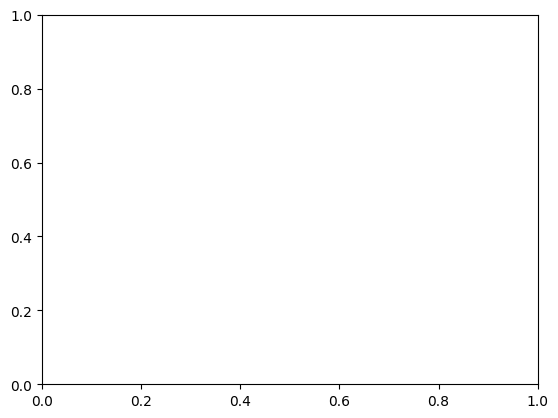

In [9]:
# fold 1
#biosnap interaction times 1e-6, flat, batch size 64, len 205, channel 3, epoch 50
s = time()
model_max, loss_history = main(1, 5e-6)
e = time()
print(e-s)
lh = list(filter(lambda x: x < 1, loss_history))
plt.plot(lh)

In [ ]:
!git add .
!git commit -m "runing moltrans for b cancer and saving csv logs"
!git push origin main